# ERA5-Land Energy Only PET Calculation

Here we use radiation components from ERA5 to calculate the Energy-Only PET between 1964-2022. We first look into the radiation components themselves and see how they relate to one another. Then, we adjust the PET-EO values for snow covered area from MODIS observations between 2001-2017. Lastly, we look at how PET changes with snow cover and elevation between wet and dry springs.

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.enums import Resampling

# First let's check out radiation components to understand how they relate in ERA5-Land


In [2]:
era5_land_net_rad = xr.open_dataset('../data/etdata/ERA5-net-radiation/era5-radiation-components.nc')

### Calculate upwelling long and shortwave radiation

In [3]:
# Shortwave upwell radiation
era5_land_net_rad['ssru'] = era5_land_net_rad['ssrd'] - era5_land_net_rad['ssr']
# Lonwave upwell radiation
era5_land_net_rad['stru'] = era5_land_net_rad['strd'] - era5_land_net_rad['str']

In [4]:
# Pull in the cloud observations and select a point
era5_clouds = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_clouds_ex = era5_clouds.sel(longitude=-107, latitude=39, method='nearest')
# calculate monthly anomalies in cloud cover
monthly_mean = era5_clouds_ex['tcc'].groupby('time.month').mean('time')
monthly_std = era5_clouds_ex['tcc'].groupby('time.month').std('time')
era5_clouds_ex['tcc_anom'] = (era5_clouds_ex['tcc'].groupby('time.month') - monthly_mean) / monthly_std

### Plot components

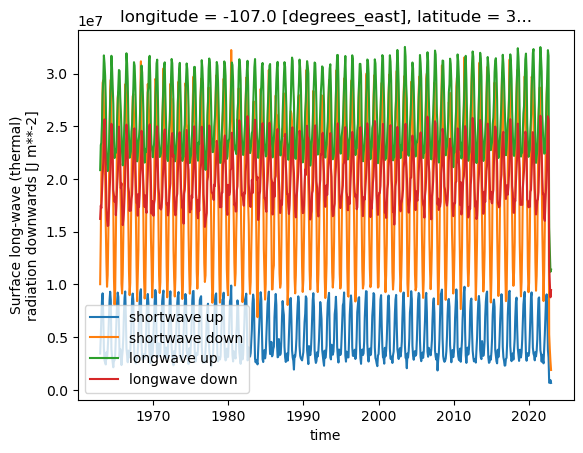

In [5]:
example = era5_land_net_rad.sel(longitude=-107, latitude=39, method='nearest')
example_monthly_mean = example.groupby('time.month').mean()
example_monthly_std = example.groupby('time.month').std()
example_anom = example.copy()
example_anom['strd_anom'] = (example['strd'].groupby('time.month') - example_monthly_mean['strd']) / example_monthly_std['strd']
example_anom['ssrd_anom'] = (example['ssrd'].groupby('time.month') - example_monthly_mean['ssrd']) / example_monthly_std['ssrd']
example_anom['stru_anom'] = (example['stru'].groupby('time.month') - example_monthly_mean['stru']) / example_monthly_std['stru']
example_anom['ssru_anom'] = (example['ssru'].groupby('time.month') - example_monthly_mean['ssru']) / example_monthly_std['ssru']
example['ssru'].plot(label='shortwave up')
example['ssrd'].plot(label='shortwave down')
example['stru'].plot(label='longwave up')
example['strd'].plot(label='longwave down')
plt.legend()

### Cloud cover increases with increasing longwave down and decreasing shortwave down

Text(0, 0.5, 'monthly upwelling shortwave radiation anomaly')

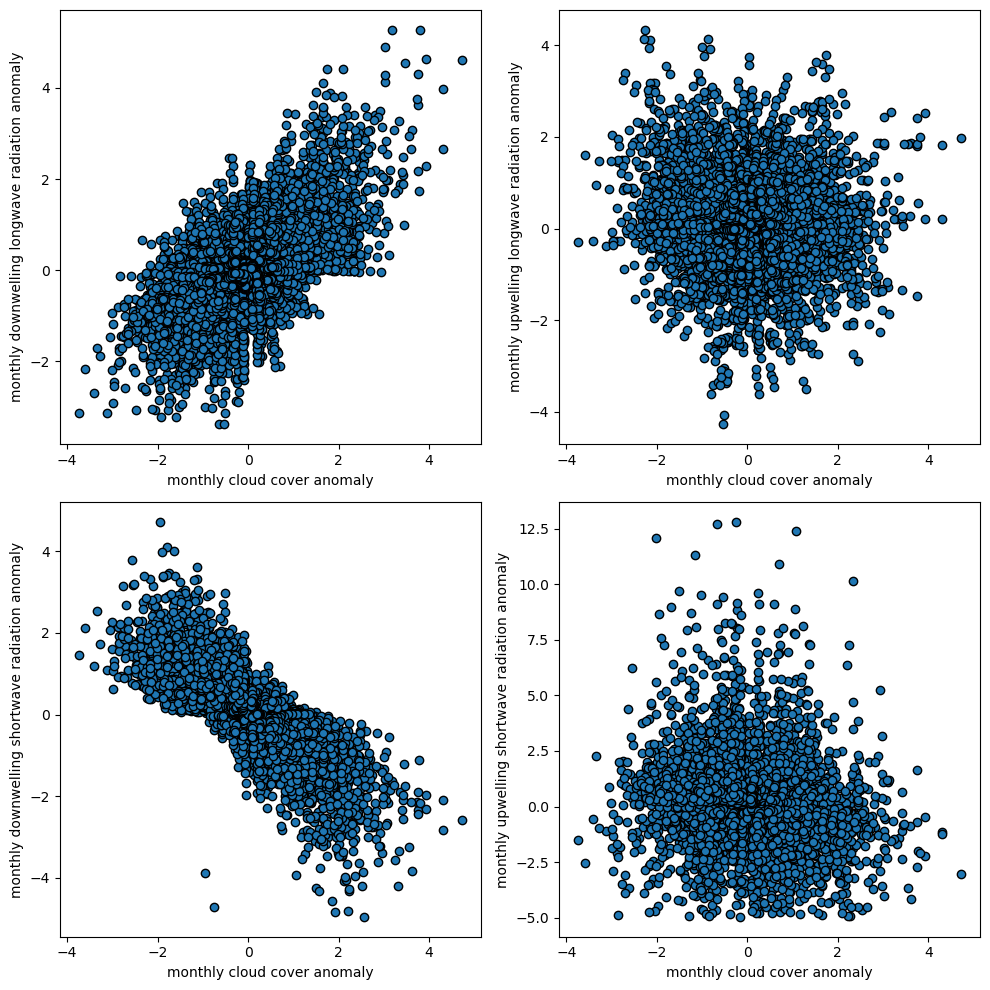

In [6]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(10, 10))   
axs[0, 0].scatter(era5_clouds_ex.where(example_anom['strd_anom']>-5)['tcc_anom'], example_anom.where(example_anom['strd_anom']>-5)['strd_anom'], ec='k')
axs[0, 0].set_xlabel('monthly cloud cover anomaly')
axs[0, 0].set_ylabel('monthly downwelling longwave radiation anomaly')
axs[1, 0].scatter(era5_clouds_ex.where(example_anom['ssrd_anom']>-5)['tcc_anom'], example_anom.where(example_anom['ssrd_anom']>-5)['ssrd_anom'], ec='k')
axs[1, 0].set_xlabel('monthly cloud cover anomaly')
axs[1, 0].set_ylabel('monthly downwelling shortwave radiation anomaly')
axs[0, 1].scatter(era5_clouds_ex.where(example_anom['stru_anom']>-5)['tcc_anom'], example_anom.where(example_anom['stru_anom']>-5)['stru_anom'], ec='k')
axs[0, 1].set_xlabel('monthly cloud cover anomaly')
axs[0, 1].set_ylabel('monthly upwelling longwave radiation anomaly')
axs[1, 1].scatter(era5_clouds_ex.where(example_anom['ssru_anom']>-5)['tcc_anom'], example_anom.where(example_anom['ssru_anom']>-5)['ssru_anom'], ec='k')
axs[1, 1].set_xlabel('monthly cloud cover anomaly')
axs[1, 1].set_ylabel('monthly upwelling shortwave radiation anomaly')

In [7]:
da = rxr.open_rasterio('../data/geodata/NLCD_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>0, np.nan)
# rename x and y to longitude and latitude
da = da.rename({'x':'longitude','y':'latitude'})

era5_land_net_rad = era5_land_net_rad.rio.write_crs('4326')
da_reproj = da.rio.reproject_match(era5_land_net_rad)
da_reproj_25 = da_reproj.where(da_reproj.isin([31]))
da_reproj_25 = da_reproj_25.where((da_reproj_25.x<-109) & (da_reproj_25.y<39))
da_reproj_10 = da_reproj.where(da_reproj.isin([51,52,71,72,73,74,81,82])) 
da_reproj_5 = da_reproj.where(da_reproj.isin([41,42,43,90,95]))

# Calculate energy only PET

### Grab MODIS SCA observations

In [8]:
# pull in ucrb modis sca
ucrb_modis_sca_fine = xr.open_dataset('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')
# add crs as 4326
ucrb_modis_sca = ucrb_modis_sca_fine.rio.write_crs(4326)
# resample to era5_land_ds grid
ucrb_modis_sca = ucrb_modis_sca.rio.reproject_match(era5_land_net_rad, resampling=Resampling.bilinear)
spring_modis_sca = ucrb_modis_sca.resample(time='1MS').max('time')


### Calculate PET-EO and adjust for snow cover

In [9]:
era5_energy_only = era5_land_net_rad.sel(time=slice('2001-03-01', '2016-05-31'))
# replae snowc with modis sca
era5_energy_only = era5_energy_only.rename({'latitude': 'y', 'longitude': 'x'})
# era5_energy_only['snowc'] = spring_modis_sca.sel(time=slice('2001-03-01', '2016-05-31')).Snow_Cover_Extent

# add crs to the data
era5_energy_only = era5_energy_only.rio.write_crs("epsg:4326")
# open ucrb boundary
ucrb = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
# clip era5 data to ucrb
era5_energy_only_clipped = era5_energy_only.rio.clip(ucrb.geometry, crs=ucrb.crs)
# sort by time
era5_energy_only_clipped = era5_energy_only_clipped.sortby('time')
# add days per month to the data
era5_energy_only_clipped['days_per_month'] = era5_energy_only_clipped.time.dt.days_in_month
# convert J/m2 to W/m2
era5_energy_only_clipped['ssr'] = era5_energy_only_clipped.ssr / (3600 * 24 )
era5_energy_only_clipped['str'] = era5_energy_only_clipped.str / (3600 * 24 )
era5_energy_only_clipped['ssrd'] = era5_energy_only_clipped.ssrd / (3600 * 24 )
era5_energy_only_clipped['strd'] = era5_energy_only_clipped.strd / (3600 * 24 )
era5_energy_only_clipped['ssru'] = era5_energy_only_clipped.ssru / (3600 * 24 )
era5_energy_only_clipped['stru'] = era5_energy_only_clipped.stru / (3600 * 24 )
# create albedo values
# when snow cover is 1, albedo is 0.8
era5_energy_only_clipped['albedo'] = 0.8 * era5_energy_only_clipped['snowc']
# when snow cover is 0, albedo is modeled albedo
era5_energy_only_clipped['albedo'] = era5_energy_only_clipped['albedo'].where(era5_energy_only_clipped['snowc'] > 10, era5_energy_only_clipped['fal'])
# when snow cover is between 0 and 1, albedo is a linear combination of the two
era5_energy_only_clipped['albedo'] = era5_energy_only_clipped['albedo'].where((era5_energy_only_clipped['snowc'] < 100) & (era5_energy_only_clipped['snowc'] > 10), 
                                                                              (0.8 * era5_energy_only_clipped['snowc'] ) + era5_energy_only_clipped['fal'] * (1 - (era5_energy_only_clipped['snowc'])))
era5_energy_only_clipped['rnet_no_change'] = (era5_energy_only_clipped['ssrd'] - era5_energy_only_clipped['ssru']) + (era5_energy_only_clipped['strd'] - era5_energy_only_clipped['stru'])
era5_energy_only_clipped['ssr_adj'] = (era5_energy_only_clipped['ssrd'] - era5_energy_only_clipped['albedo']*(era5_energy_only_clipped['ssrd']))

era5_energy_only_clipped['rnet_adj'] = (era5_energy_only_clipped['ssr_adj']) + (era5_energy_only_clipped['strd'] - era5_energy_only_clipped['stru'])
# set negative values to 0
era5_energy_only_clipped['rnet_adj'] = era5_energy_only_clipped['rnet_adj'].where(era5_energy_only_clipped['rnet_adj'] > 0, 0)

# for all cells with snow cover over, set PET to 0
era5_energy_only_clipped['rnet_zero'] = (era5_energy_only_clipped['ssr'] + era5_energy_only_clipped['str'])
era5_energy_only_clipped['rnet_zero'] = era5_energy_only_clipped['rnet_zero'].where((era5_energy_only_clipped['snowc'] >=0) & (era5_energy_only_clipped['snowc'] <100), 0)
# clip values to ucrb boundary
era5_energy_only_clipped = era5_energy_only_clipped.rio.clip(ucrb.geometry, crs=ucrb.crs)

### Before we move on, let's compare ERA5-land albedo to observations from MODIS from Jia et al. (2022)

In [10]:
# modis albedo climatology
import glob

In [11]:
modis_albedo_files = glob.glob('../data/snowdata/albedo/monthly_clim/*.nc')


Grab albedo observations over a large portion of the UCRB headwaters

In [12]:
albedo = []
for i,file in enumerate(sorted(modis_albedo_files)):
    modis_albedo = xr.open_dataset(file)
    if i in [0,1,2,3,4,10,11]:
        val = modis_albedo['hist_alb_clim'].isel(longitude=slice(1400,1450), latitude=slice(940,990)).max() # median() mean()
    else:
        val = modis_albedo['hist_alb_clim'].isel(longitude=slice(1400,1450), latitude=slice(940,990)).mean() # median() mean()
    albedo.append(val.values)

In [13]:
example = era5_land_net_rad.sel(longitude=slice(-108,-106), latitude=slice(40,38)).mean(['latitude', 'longitude'])
example_2 = spring_modis_sca.sel(x=slice(-108,-106), y=slice(40,38)).mean(['x', 'y'])

Build a comparison plot between MODIS fSCA and albedo and ERA5-land fSCA and albedo by month. Note the difference in albedo during winter.

Text(0.5, 1.0, '')

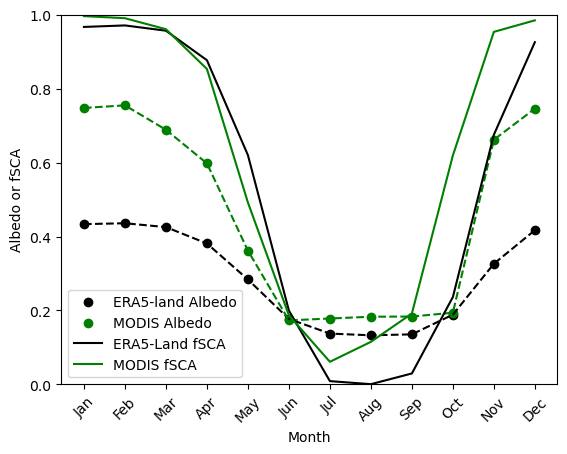

In [14]:
example = era5_land_net_rad.sel(longitude=slice(-108,-106), latitude=slice(40,38)).mean(['latitude', 'longitude'])
example_2 = spring_modis_sca.sel(x=slice(-108,-106), y=slice(40,38)).mean(['x', 'y'])
monthly_example = example.groupby('time.month').mean()
monthly_example2 = example_2.groupby('time.month').mean()
plt.scatter(x=monthly_example.month, y=monthly_example['fal'], label = 'ERA5-land Albedo', color='k')
monthly_example['fal'].plot( color='k', ls='--')
plt.scatter(x=monthly_example.month, y=albedo, label='MODIS Albedo', marker='o', color='green')
plt.plot(monthly_example.month, albedo, ls='--', color='green')


# (monthly_example['ssru']/monthly_example['ssrd']).plot(label='calculated albedo', ls='--')
# monthly_example['asn'].plot(label = 'snow albedo')
(monthly_example['snowc']/100).plot(label='ERA5-Land fSCA', color='k')
monthly_example2['Snow_Cover_Extent'].plot(label='MODIS fSCA', color='green')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Albedo or fSCA')
plt.ylim(0,1)
# change x labels to month names and rotate 45
plt.xticks(ticks=monthly_example.month, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45);

# plt.title('Albedo and fSCA from ERA5-Land and MODIS over selected headwater basins\n(2001-2017 climatology)')
plt.title('')

### Final calculation of energy only PET

In [15]:
# energy only et 
rho = 1000
L = 2.5e6
era5_energy_only_clipped['et_eo'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_no_change'] / (rho * L)) * era5_energy_only_clipped.days_per_month
era5_energy_only_clipped['et_eo_adj'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_adj'] / (rho * L)) * era5_energy_only_clipped.days_per_month
era5_energy_only_clipped['et_eo_zero'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_zero'] / (rho * L)) * era5_energy_only_clipped.days_per_month


In [16]:
# save to netcdf
# era5_energy_only_clipped.to_netcdf('../data/etdata/ERA5_energy_only_clipped.nc')

In [17]:
# open hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
# convert to 4326
hcdn_basins = hcdn_basins.to_crs("epsg:4326")

In [ ]:
era5_energy_only_clipped['et_eo_zero']

Compare values of PET without cloud cover and with it

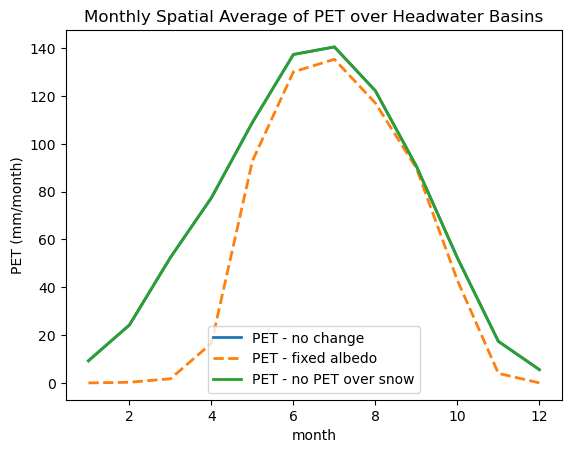

In [135]:
example = era5_energy_only_clipped.rio.clip(hcdn_basins.geometry, crs=hcdn_basins.crs).mean(dim=['x', 'y'])
example['et_eo'].groupby('time.month').mean().plot(label='PET - no change', lw=2)
example['et_eo_adj'].groupby('time.month').mean().plot(label='PET - fixed albedo', lw=2, ls='--')
example['et_eo_zero'].groupby('time.month').mean().plot(label='PET - no PET over snow', lw=2)
plt.ylabel('PET (mm/month)')
plt.title('Monthly Spatial Average of PET over Headwater Basins')
plt.legend()

# Plot Change in PET with elevation and snow cover
### Grab land cover data

In [99]:
da = rxr.open_rasterio('../data/geodata/NLCD_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>0, np.nan)

In [100]:
da_reproj = da.rio.reproject_match(era5_energy_only_clipped)
da_reproj_25 = da_reproj.where(da_reproj.isin([31]))
da_reproj_25 = da_reproj_25.where((da_reproj_25.x<-109) & (da_reproj_25.y<39))
da_reproj_10 = da_reproj.where(da_reproj.isin([51,52,71,72,73,74,81,82])) 
da_reproj_5 = da_reproj.where(da_reproj.isin([41,42,43,90,95]))

### Grab ERA5-Land cloud cover data and radiation variables

In [101]:
era5_net = (era5_energy_only_clipped.ssr + era5_energy_only_clipped.str)
# these adjustments are for ground heat flux, but make no difference, so ignored
# era5_net = era5_net - 0.05 * (era5_net * da_reproj_5.notnull()) 
# era5_net = era5_net - 0.1 * (era5_net * da_reproj_10.notnull())
# era5_net = era5_net - 0.25 * (era5_net * da_reproj_25.notnull())
era5_net = era5_net.rename('net_radiation')
era5_net = era5_net.rio.write_crs("epsg:4326")

In [102]:
# load raw era5 data
era5_eo_clipped = xr.open_dataset('../data/etdata/ERA5-Land-PT-PET-vars.nc')
# add crs
era5_eo_clipped = era5_eo_clipped.rio.write_crs("epsg:4326")
# load cloud cover data from ERA5
era5_cc = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc').tcc
era5_cc = era5_cc.rio.write_crs(4326)
# rename latitudes and longitudes to x and y
era5_cc = era5_cc.rename({'latitude': 'y', 'longitude': 'x'})
# clip to ucrb
era5_cc = era5_cc.rio.clip(ucrb.geometry, crs=ucrb.crs)
era5_net_matched = era5_net#.rio.reproject_match(era5_cc)
era5_2m_temp = era5_eo_clipped['t2m'].rio.reproject_match(era5_cc)
era5_pet = era5_energy_only_clipped['et_eo']
# replace large values with nan
era5_net_matched = era5_net_matched.where(era5_net_matched < 100000, np.nan)

In [103]:
# get spring average era5_cc
era5_cc_spring = era5_cc.sel(time=era5_cc.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')

# get spring average era5_net
era5_net_spring = era5_net_matched.sel(time=era5_net_matched.time.dt.month.isin([3,4,5])).groupby('time.year').sum('time')
# get spring average era5_2m_temp
era5_2m_temp_spring = era5_2m_temp.sel(time=era5_2m_temp.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')
# get spring average era5_pet
era5_pet_spring = era5_pet.sel(time=era5_pet.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')

In [ ]:
# filter to treed areas (41,42,43)
treed_areas_fine = da.where(da.isin([41,42,43]),drop=True)
# untreed areas
untreed_areas = da.where(~da.isin([41,42,43]),drop=True)
# reproject tmean to match era5
treed_areas = treed_areas_fine.rio.reproject_match(era5_energy_only_clipped)
untreed_areas = untreed_areas.rio.reproject_match(era5_energy_only_clipped)
# make values less than 0 nan
treed_areas = treed_areas.where(treed_areas>=0,np.nan)
untreed_areas = untreed_areas.where(untreed_areas>=0,np.nan)


### <a id='toc1_1_1_'></a>[PRISM UCRB Temperature](#toc0_)

In [104]:
# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1930-01-01','2022-09-30'))


In [105]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)

# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

### Create a subset of the data for snow cover comparisons

In [136]:
# resample to monthly mean
monthly_ucrb_modis_sca = ucrb_modis_sca.resample(time='1MS').mean()

# add crs
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.write_crs(4326)
# reproject to match era5_energy_only_clipped
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.reproject_match(era5_energy_only_clipped, resampling=Resampling.bilinear).sel(time=slice('2000-03-01','2016-06-01'))

# era5 subset
era5_subset = era5_energy_only_clipped.sel(time=slice('2001-03-01','2016-06-01'))


### Create hyposmetric plot for tree cover

In [137]:
# make a hypsometric plot of PET with elevation
era5_data = era5_subset.where(era5_subset.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
#era5_subset_masked.where(era5_subset_masked.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')

# replace 0 with nan
era5_data = era5_data.where(era5_data>=0,np.nan)
# replace unrealistic values > 1000 with nan
# era5_data = era5_data.where((era5_data<900) | (~era5_data.notnull()),800)
# add the elevation data
dem_fine = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif').squeeze()
# calculate the area of 100 m elevation bins
dem_area = dem_fine.copy()
dem_area.name='elevation'
# convert to dataset
dem_area = dem_area.to_dataset()
dem_area = dem_area.rio.reproject_match(era5_data, resampling=Resampling.bilinear)
dem_area = dem_area.where(dem_area>0,np.nan)
# convert dem resolution to meters
area = np.full_like(dem_area.squeeze().to_array()[0], 10130.37725989001 * 10130.37725989001)
# add the area of each grid cell to the dataset
dem_area['area'] = xr.DataArray(area, coords=dem_area.coords)


# reproject to match era5
dem = dem_fine.rio.reproject_match(era5_data)
# make values less than 0 nan
dem = dem.where(dem>0,np.nan)
# add the elevation data to the era5 data
era5_data['elevation'] = dem
# add elevation to treed areas
if type(treed_areas_fine) != xr.core.dataset.Dataset:
    treed_areas_fine.name = 'tree_cover'
    treed_areas_fine = treed_areas_fine.to_dataset()
dem_tree = dem_fine.rio.reproject_match(treed_areas_fine, resampling=Resampling.bilinear)
treed_areas_fine['elevation'] = dem_tree
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover'].notnull(),0)
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover']==0,1)

In [138]:
# resample to monthly mean
monthly_ucrb_modis_sca_fine = ucrb_modis_sca_fine.resample(time='1MS').mean()

In [139]:
# get ready to plot modis SCA
spring_modis_sca = monthly_ucrb_modis_sca_fine.where(monthly_ucrb_modis_sca_fine.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').mean()

# add dem to modis sca
dem_sca = dem_fine.rio.reproject_match(spring_modis_sca)
# replace values less than 0 with nan
dem_sca = dem_sca.where(dem_sca>0, np.nan)
spring_modis_sca['elevation'] = dem_sca

In [116]:
tree_covered_area = rxr.open_rasterio('../data/geodata/nlcd_landcover/ucrb_tree_cover_fraction_cleaned.tif').squeeze()
# resample to 150 m resolution
tree_covered_area = tree_covered_area.rio.reproject_match(dem_fine, resampling=Resampling.bilinear)

# crop to ucrb
tree_covered_area = tree_covered_area.rio.clip(ucrb.to_crs(32613).geometry, all_touched=True)
# replace values above 100 with nan
tree_covered_area = tree_covered_area.where(tree_covered_area<=100,np.nan)
# convert to dataset and name 
tree_covered_area.name = 'tree_cover'
tree_covered_area = tree_covered_area.to_dataset()
# add the dem
tree_covered_area['elevation'] = dem_fine

In [117]:
tree_covered_area_bins = (tree_covered_area.groupby_bins('elevation', np.arange(tree_covered_area.elevation.min(),
                                  tree_covered_area.elevation.max(),
                                  100)).mean().tree_cover/100)

In [140]:
# add dem to net radiation
dem_era5_rnet = dem.rio.reproject_match(era5_net_matched) 
era5_net_matched_ds = era5_net_matched.to_dataset()
era5_net_matched_ds['elevation'] = dem_era5_rnet

# add dem to cloud cover
era5_cc_ds = era5_cc.to_dataset()
# rename latitude and longitude to y and x
era5_cc_ds['elevation'] = dem_era5_rnet

### Bin cloud cover, et, and cloud cover in spring

In [142]:
binned_rnet = era5_net_matched_ds.groupby_bins(era5_net_matched_ds.elevation, bins=np.arange(era5_net_matched_ds.elevation.min(),era5_net_matched_ds.elevation.max(),100)).mean().net_radiation
binned_cc = era5_cc_ds.groupby_bins(era5_cc_ds.elevation, bins=np.arange(era5_cc_ds.elevation.min(),era5_cc_ds.elevation.max(),250)).mean().tcc

In [143]:
# calculate the binned averages during spring
binned_rnet_spring = binned_rnet.where(binned_rnet.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').sum()
binned_cc_spring = binned_cc.where(binned_cc.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').mean()
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo 

Text(0.5, 1.0, 'Area Normalized Total Spring PET')

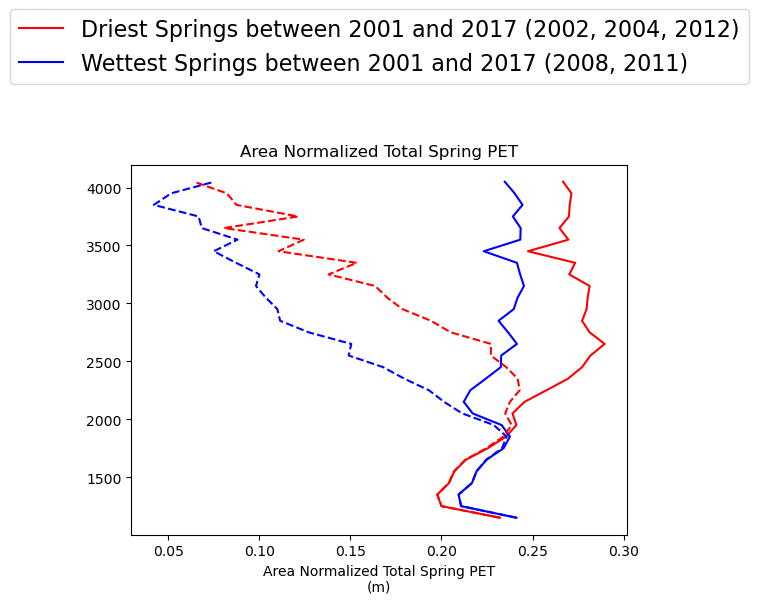

In [147]:
fig, ax = plt.subplots()
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Driest Springs between 2001 and 2017 (2002, 2004, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wettest Springs between 2001 and 2017 (2008, 2011)')

binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo_adj / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='r', 
ls='--',)
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
ls='--',)


ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.32), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')


### Select wet and dry springs for comparison. These were selected from springs with >1 std above or below the mean spring precipitation.

In [40]:
one = spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2002,2012]).mean('year')
two = spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2009,2011]).mean('year')
(one-two).isel(elevation_bins=slice(13,18)).mean()

<xarray.DataArray 'Snow_Cover_Extent' ()>
array(-0.22178419, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

# Plot included in main text showing PET change with elevation between wet and dry years

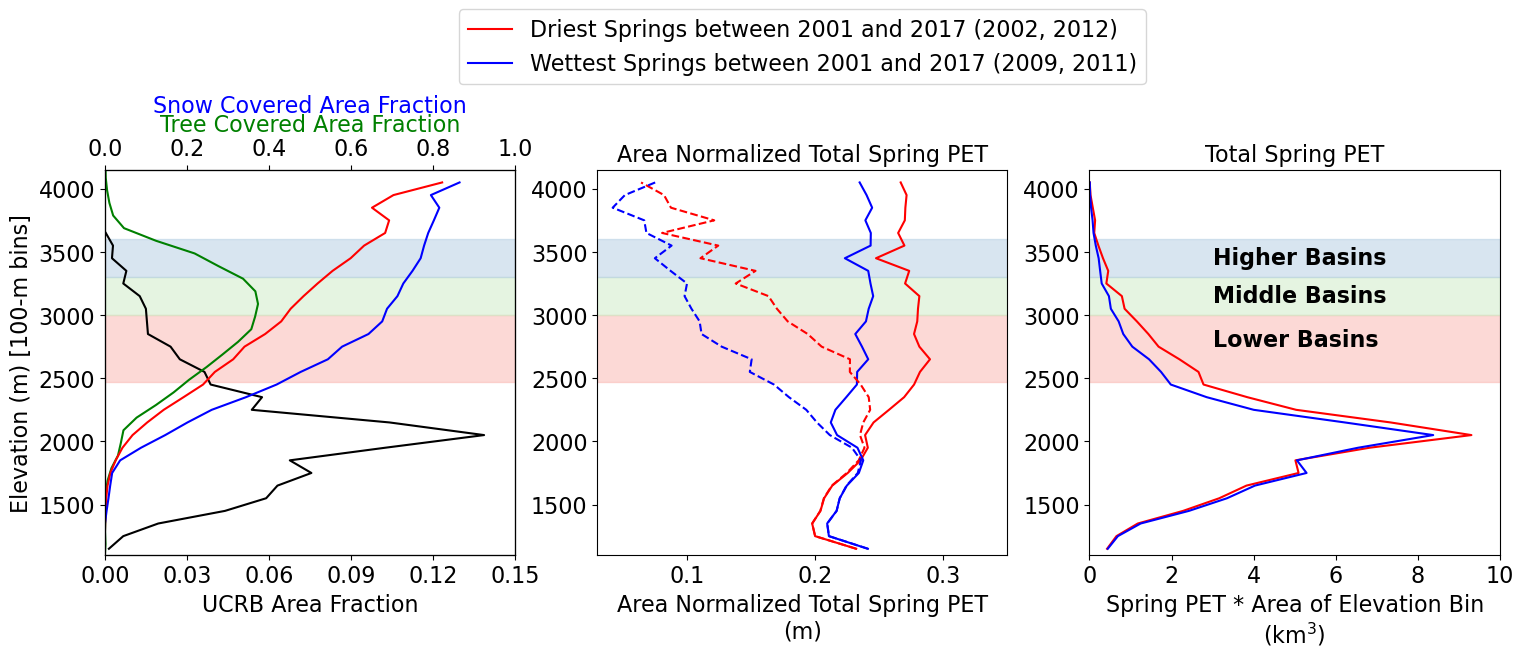

In [168]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
ax = axs[0]
((dem_area.groupby_bins('elevation',
                        np.arange(era5_data.elevation.min(),
                                  era5_data.elevation.max(),
                                  100)).sum()).area/(dem_area.groupby_bins('elevation',
                                                                           np.arange(era5_data.elevation.min(),
                                                                                     era5_data.elevation.max(),
                                                                                     100)).sum()).area.sum()).plot(y='elevation_bins', 
                                                                                                                   ax=ax,
                                                                                                                   color='k')
ax.set_xlabel('UCRB Area Fraction')
ax2 = ax.twiny()
tree_covered_area_bins.plot(y='elevation_bins',ax=ax2, color='g')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                                                                                                ax=ax2, 
                                                                                                                                color='r', 
                                                                                                                                label='Dry Spring (2002)')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2009,2011]).mean('year').plot(y='elevation_bins',
                                                                                                                           ax=ax2, 
                                                                                                                           color='b', 
                                                                                                                           label='Wet Spring (2011)')
ax2.set_xlabel('Tree Covered Area Fraction', color='g', fontsize=16)
# make the ticks green
for tl in ax2.get_xticklabels():
    tl.set_color('k')
    tl.set_fontsize(16)
ax2.tick_params(axis='x', colors='k')
ax2.set_xlim(0,1)
ax2.set_title('')
# add another axis on top of ax2
ax3 = ax.twiny()
ax3.set_xlim(0,1)
ax3.set_xlabel('Snow Covered Area Fraction', color='b', fontsize=16)
# move the xlable up a bit
ax3.xaxis.set_label_coords(0.5, 1.15)
# turn off the ticks and tick labels

ax3.set_xticks([])
ax3.set_xticklabels([])


ax.set_ylabel('Elevation (m) [100-m bins]')
ax.set_title('')
ax.set_xlim(0,0.15)
ax.set_xticks(np.arange(0,0.16,0.03))

ax = axs[1]
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo / 1000
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                        ax=ax, 
                                                        color='r', 
                                                        label = 'Driest Springs between 2001 and 2017 (2002, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
                                                        ax=ax, 
                                                        color='b',
                                                        label = 'Wettest Springs between 2001 and 2017 (2009, 2011)')
band_diff_1 = binned_et_eo.sel(year=[2002,2012]).mean('year') - binned_et_eo.sel(year=[2009, 2011]).mean('year')

binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo_adj / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                    ax=ax, 
                                                    color='r', 
                                                    ls='--',)
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
                                                    ax=ax, 
                                                    color='b',
                                                    ls='--',)
band_diff_2 = binned_et_eo.sel(year=[2002,2012]).mean('year') - binned_et_eo.sel(year=[2009, 2011]).mean('year')
ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.32), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')
ax.set_xlim(0.03,0.35)


ax = axs[2]
binned_et_eo = era5_data.where(era5_data.elevation>0).groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().et_eo_adj / 1000
binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9

binned_et_eo.sel(year=[2002, 2012]).mean('year').plot(y='elevation_bins',
                                                            ax=ax, 
                                                            color='r', 
                                                            label = 'Driest Springs (2002, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wettest Spring (2009, 2011)')
ax.set_xlabel('Spring PET * Area of Elevation Bin\n(km$^3$)')
ax.set_ylabel('')
ax.set_title('Total Spring PET')
ax.set_xlim(0,10)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 2800,'Lower Basins ', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3150,'Middle Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3450,'Higher Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
for ax in axs:
    ax.set_ylim(era5_data.elevation.min(),era5_data.elevation.max())
    # increase the font size for all x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    # increase the font size for x and y labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    # add a horizontal band between 2470 and 2900
    ax.axhspan(2470, 3000, color='#fbb4ae', alpha=0.5,)
    
    # add a horizontal band between 2900 and 3200
    ax.axhspan(3000, 3300, color='#ccebc5', alpha=0.5,)
    
    # add a horizontal band between 3200 and 3600
    ax.axhspan(3300, 3600, color='#b3cde3', alpha=0.5,)

# fig.suptitle('Hypsometric Plot of Spring PET (Energy-Only) and Elevation', fontsize=20, y=1.2)

Show the difference between each headwater elevation band

In [167]:

print(band_diff_2.isel(elevation_bins=slice(9,12)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(13,15)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(16,20)).mean().values)

0.07802238967000809
0.05729366679869981
0.02547166353191982


0.07661268680165752
0.05668501995912042
0.028060348261226314


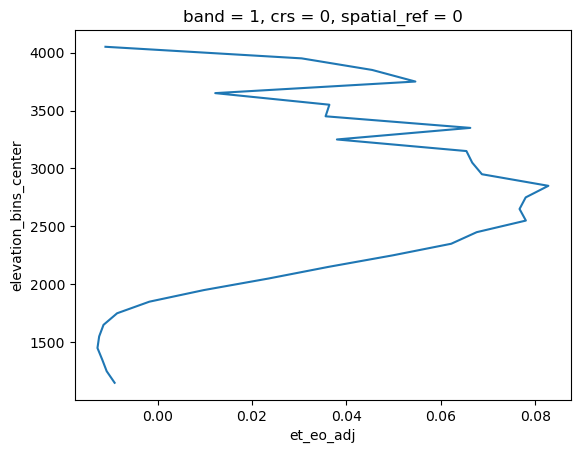

In [169]:
print(band_diff_2.isel(elevation_bins=slice(13,18)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(19,22)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(23,26)).mean().values)